# Synopsis

The analysis here tackles the problem of revealing very low contrast and short duration temporal information from a sequence of radiographic images while elucidating spatial characteristics.

The method presented tracks grayscale values changes in a sequence of radiographs which are then decomposed into a set of component breakthrough profiles and coefficients using principal component analysis. Component saturation profiles, together with respective coefficients are used to provide insights into the distribution of initial liquid water breakthrough of an operating test cell with sample water movement. Some error analysis on the PCA method using bootstrapping is also presented.

The results of analyzing the rawa image reveal the decomposition of components including vignettes image artefacts that could now aid image information retrieval, spatial distribution of dominant water movement



## Import Packages

In [108]:
import os
import sys
import numpy as  np
from skimage.io import imread, imsave
from skimage import filters
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from sklearn.decomposition import PCA
import pickle
%matplotlib inline


plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 13

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import own modules

In [109]:
own_package_paths = ['..\\src']
sys.path += own_package_paths

from data import processing
from models import model

## Reading data and Pre-processing
Image data is a sequence of radiographs taken at 4 second intervals while the sample is operational. The liquid water has a very low contrast such that it is not readily visible in the raw image

In [110]:
im = imread(os.path.normpath('../data/raw/radiograph-seq.tiff'))
im = im[:9].copy()
im_shape = im.shape

In [111]:
filtered_im = processing.filter_image(im, sigma=3)

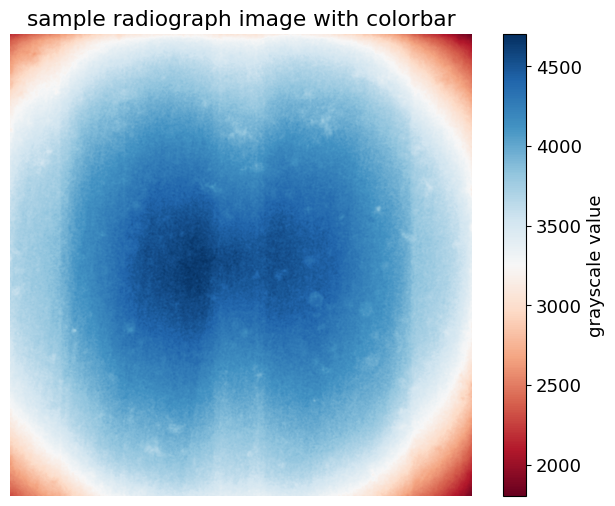

In [123]:
fig, ax = plt.subplots()

p = ax.imshow(filtered_im[0], cmap='RdBu')
ax.axis('off');
ax.set_title('sample radiograph image with colorbar')

plt.colorbar(p, label='grayscale value');

fig.savefig('../reports/images/raw_radiograph.png')

Each radiograph is such that the liquid water information is difficult to discern due to the low signal intensity of the liquid water information of interest. 

## Tranformation for PCA

The idea proposed is the extract temporal variations due to the signal of interest from the overall variation in the images. To do this, line profiles are extracted from corresponding pixel location across the image seqeunces as illustrated in the figure below:

<a id='data_setup_image'></a>

*Figure illustrating the setup and transformation of the image dataset to serve as input
to the PCA algorithm. The first section shows a sample profile extracted from the image sequence. Similar profiles are obtained across the image plane to form a matrix which then serves as input to the PCA algorithm to yield the PCs and projections*

![Illustrating the setup and transformation of the image dataset to serve as input
to the PCA algorithm](../reports/images/data-setup.PNG)

First, individual saturation profiles are extracted from the sequence of radiograph to form a matrix, $X$ as illustrated in the [Figure](#data_setup_image).
Given a sequence of images ${I_1, \ldots , I_d}$ where each image $I_i$ is of dimension $r$ by $c$ (representing the number of rows and columns respectively), a vector $x_i$ may be formed which consist of a point $(i, j)$ in each image in the sequence, such that $x_i$ consists of the values $\left(I_1(i, j), I_2(i, j), \ldots , I_d(i, j)\right)$. When we consider all such points $(i, j)$ in the plane, we have a set vectors $X = {x_1, x_2, \ldots , x_{r \times c}}$ which can be represented as a matrix $X$ of dimension $n$ by $d$, where $n = r \times c$.  %Essentially, 
Each vector in the matrix $X$ now consists of the GSV profile for each point in the image plane, from which relevant liquid water distribution and dynamics may be extracted.

A sample from these set of vectors is shown in [Figure](#data_setup_image), featuring different GSV profiles present for different regions of the image plane.

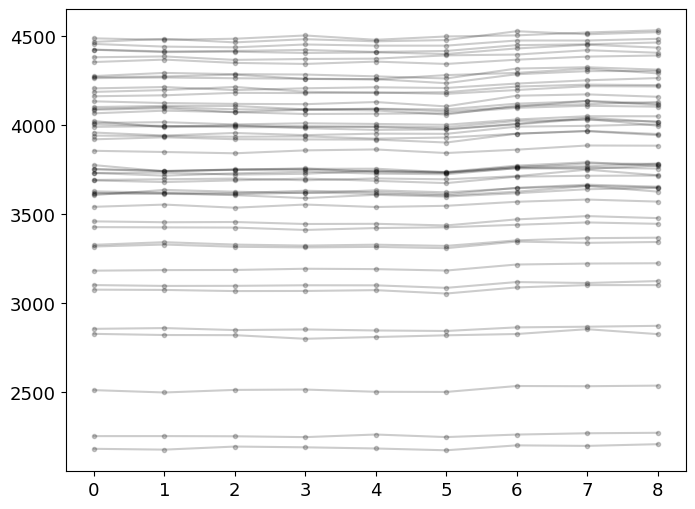

In [113]:

n_seq, n_row, n_col = np.shape(filtered_im)

X = filtered_im.reshape(n_seq, -1).T

fig, ax = plt.subplots()

n = 50

sample_idx = np.random.choice(np.arange(X.shape[0]), size=n, replace=False )
x = X[sample_idx, :]
ax.plot( x.T, '.-', c='black', alpha=0.2);

## PCA Modelling

The PCs are obtained by first computing the covariance matrix $X$ given by $S = \frac{X^T X}{n-1}$, followed by the spectral decomposition of $S$  given by $S = PDP^T$. Here $D$ is a diagonal matrix with eigen values $(\lambda_1, \ldots , \lambda _d)$, such that $\lambda _1 \ge \lambda _2 \ldots \ge  \lambda _d$, and $P = (v_1, \ldots ,  v_d)$ is a matrix of orthogonal vectors which are the PCs. Each eigen value, $\lambda_i$ is a measure of the variance in the dataset, explained by its corresponding eigen vector $v_i$. The fraction of the total variance (FTV) explained by $v_i$ may therefore be expressed as given in the equation. This proportion gives an indication of the relative importance of the respective PC.   

\begin{align}
    FTV = \frac{\lambda _i}{\lambda _1 + \ldots + \lambda _d}
    \label{prop-var}
\end{align}


The coefficients $(Y_1, \ldots , Y_n)$ are obtained by  projecting each vector in $X$ on the space now defined by the principal axis. Each coefficient, $Y_i$ is a $d$-dimensional vector given by $Y_i = P^Tx_i$.

In [114]:
model = model.get_model()
pca = pca.fit(X)
ftv = pca.explained_variance_[0:] / np.sum(pca.explained_variance_[0:])

X_pca = pca.transform(X)
X_mean = np.mean(X, axis=0)

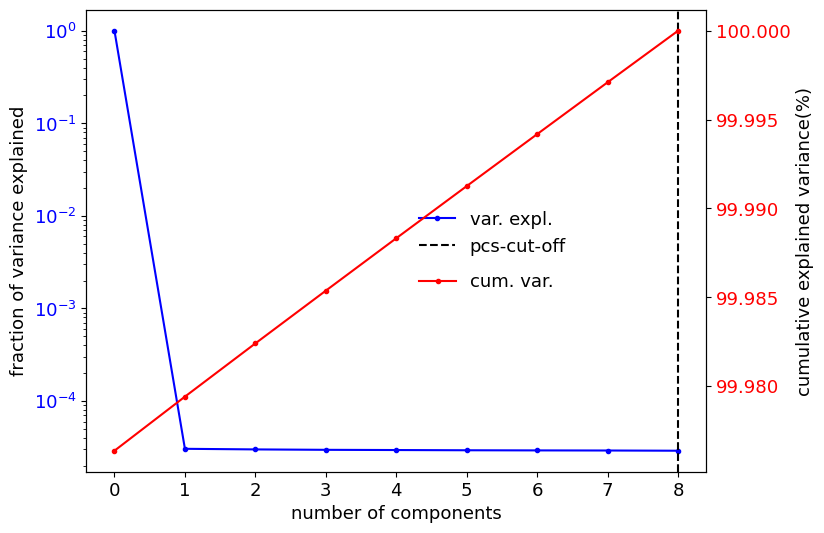

In [115]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
#ax2.plot(np.cumsum(pca.explained_variance_ratio_*100.0), '-.', c='r',  label='cum. var.')
ax2.plot(np.cumsum(ftv*100.0), '.-', c='r',  label='cum. var.')
ax.set_xlabel('number of components')
ax2.set_ylabel('cumulative explained variance(%)');
ax2.ticklabel_format(useOffset=False)


ax.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax.semilogy(np.arange(X.shape[1])[0:], pca.explained_variance_ratio_[0:], '.-', c='b', label='var. expl.')

ax.set_ylabel('fraction of variance explained')

ax.axvline(x=8,  ls='--', c='black', label='pcs-cut-off')

ax.legend(bbox_to_anchor=(0.8,0.6), frameon=False)
ax2.legend(bbox_to_anchor=(0.78,0.465), frameon=False)
ax.grid(False)
ax2.grid(False)

The first PC captures about $99.98\%$ of the variation in the dataset and this is due to the global intensity variation due to illumination artifacts. All other components capture other variations, including due to liquid water effects with decreasing FTV for subsequent component. The cumulative plots make the contribution of each additional PC to the total variation more evident. Starting with an initial rise, the cumulative curve the appears to turn linear after 8 components, suggesting that additional PCs beyond this point have very close FTV, and capture the least amount of variance in the saturation profiles. For analysis, we therefore focus on the first 8 components which contribute most significantly to the variation in the saturation profiles.

## Interpreting Principal Components

It is possible to reconstruct a pair of profile and corresponding image map  from the PCs and coefficients, respectively.

The image map will feature high intensity values for regions where the signal indicated by the profile constitute a significant component.

### Principal Components (PCs)

To visualize this, the figure below shows the first 8 PCs (and the mean in the first plot), together with the percentage of variance explained in each plot title. What can be seen from the plot is that the first components captures a large share of the variance in the data at about $99.98\%$. The next set of PCs are of a lower order contribution, whereby the change from the second to the third appears significant but subsequent changes decrease precipitously as the number of components increase.

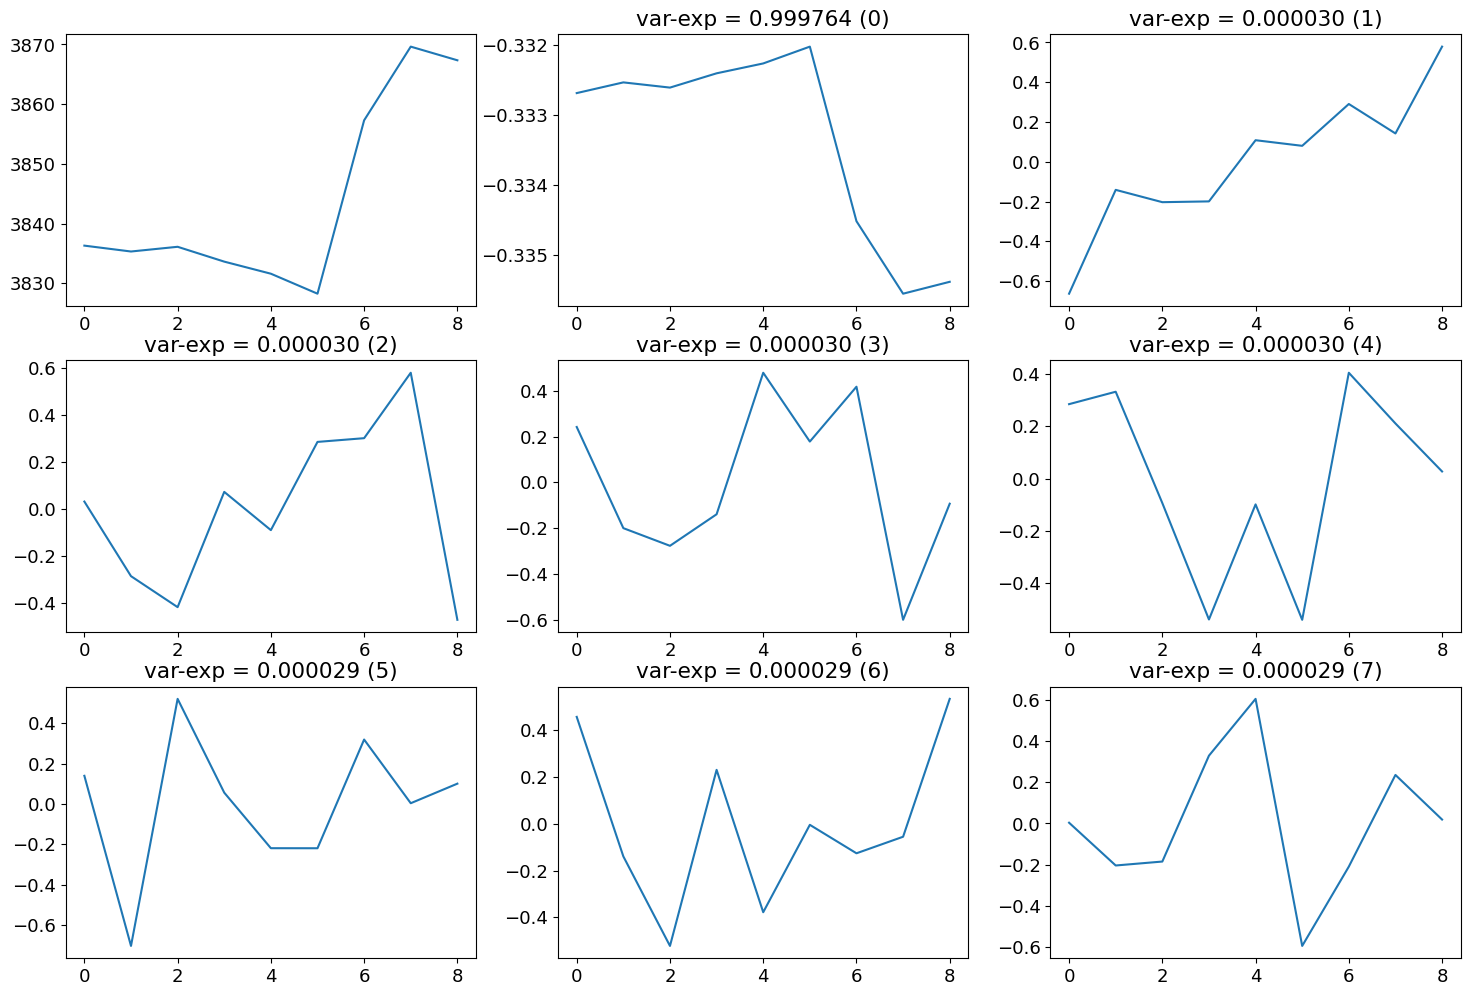

In [116]:
n_comp=8
fig, axs = plt.subplots(n_comp//3+1, 3, figsize=(18, 12))
axs = axs.flatten()
for comp in np.arange(n_comp):
    ax = axs[comp+1]
    ax.plot(pca.components_[comp])
    ax.set_title(f"var-exp = {pca.explained_variance_ratio_[comp]:.6f} ({comp})")
axs[0].plot(X_mean);

extent = axs[2].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('../reports/images/pc1.png', bbox_inches=extent.expanded(1.2, 1.2))

### Image Maps (co-efficients)
 
The image maps of coefficients  are shown in the figure below and these show the projection of each location profile on the corresponding PCs, with magnitude values that may be read off the color bar.

It is striking how we are now able to see liquid water droplet location previously invisible in the raw images

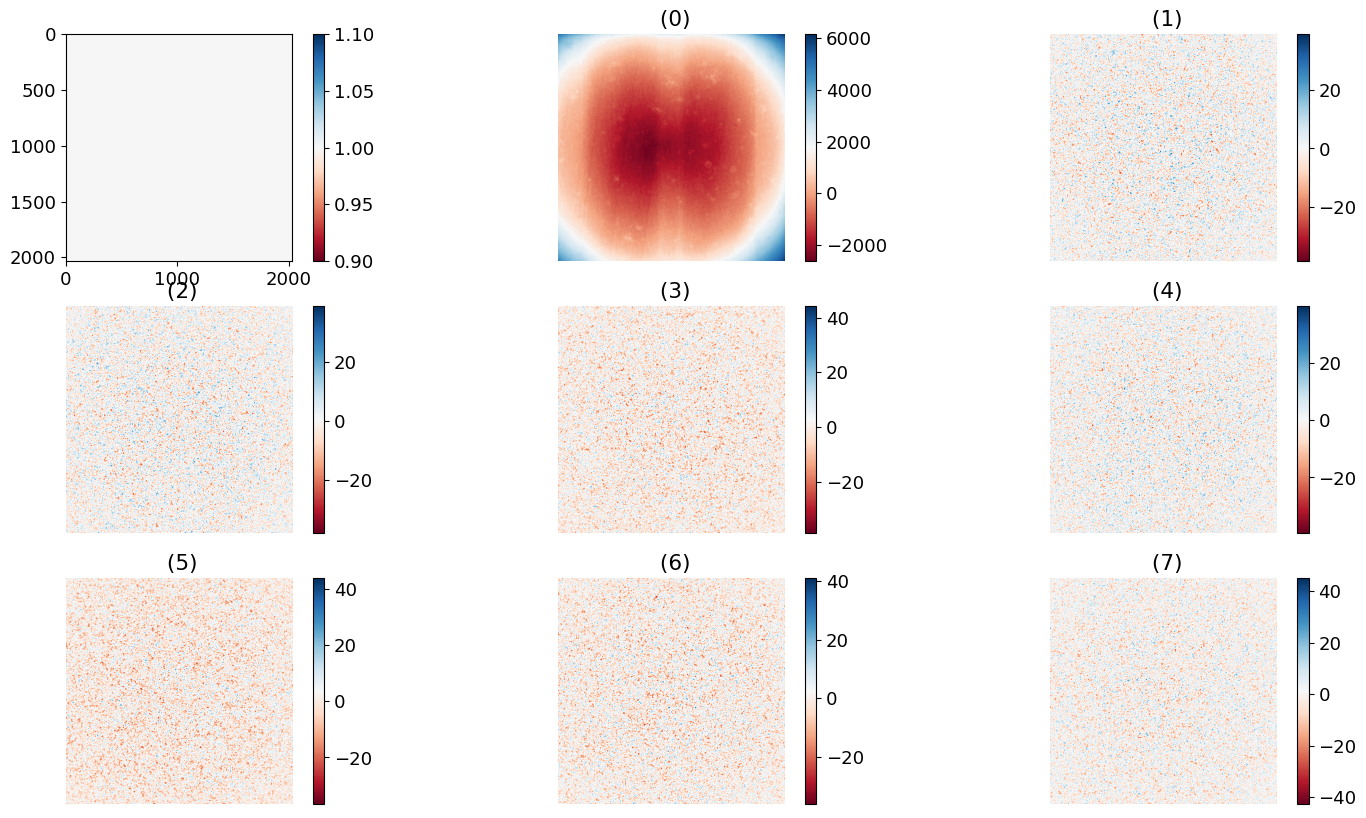

In [117]:
n_comp = 8
fig, axs = plt.subplots(n_comp//3+1, 3, figsize=(18, 10))
axs = axs.flatten()
for i in np.arange(n_comp):
    ax = axs[i+1]
    pcm = ax.imshow(X_pca[:, i].reshape(filtered_im.shape[1], filtered_im.shape[2]), cmap='RdBu')
    ax.set_title(f" ({i})")
    ax.axis('off')
    fig.colorbar(pcm, ax=ax)

mean_eigen_value = np.ones((filtered_im.shape[1], filtered_im.shape[2]))
pcm = axs[0].imshow(mean_eigen_value, cmap='RdBu')
fig.colorbar(pcm, ax=axs[0])
plt.show()

The line profile given by the PCs carries information of the localized liquid water breakthrough characteristic and combining this information with the percentage of variance explained gives an indication of the dominant flow profiles  in order. The reconstructed image maps from the projection coefficients encode the contribution of a given saturation profile to a particular pixel location, thereby yielding liquid water distribution information.

## Noise analysis: get error bars around components

The data collected in the radiograph contains some noise and it is necessary to investigate the effects
of noise on the results obtained from the analysis. In addition, it may be difficult to interpret the PCs
without a measure of variation around the values since PCA is sensitive to noise [[11]](https://royalsocietypublishing.org/doi/10.1098/rsta.2015.0202)

To investigate this, we  check the robustness of the PCs by employing a **bootstrap resampling method**. This involves generating random sample sets -- in this case, from the set of profiles in $X$ -- by sampling the original data with replacement.

The result of the expensive computation is also saved on disk

In [118]:
# retrieve or compute error bars

fname = "component_error"
try:
    with open('../results/'+fname, 'rb') as handle:
        mean_std, comp_std = pickle.load(handle)
except FileNotFoundError as e:
    print(f"{e} \n computing")
    mean_std, comp_std = model.get_component_error(X, n_samples=3)
    with open('../results/'+fname, 'wb') as handle:
        pickle.dump((mean_std, comp_std), handle, protocol=pickle.HIGHEST_PROTOCOL)

<ErrorbarContainer object of 3 artists>

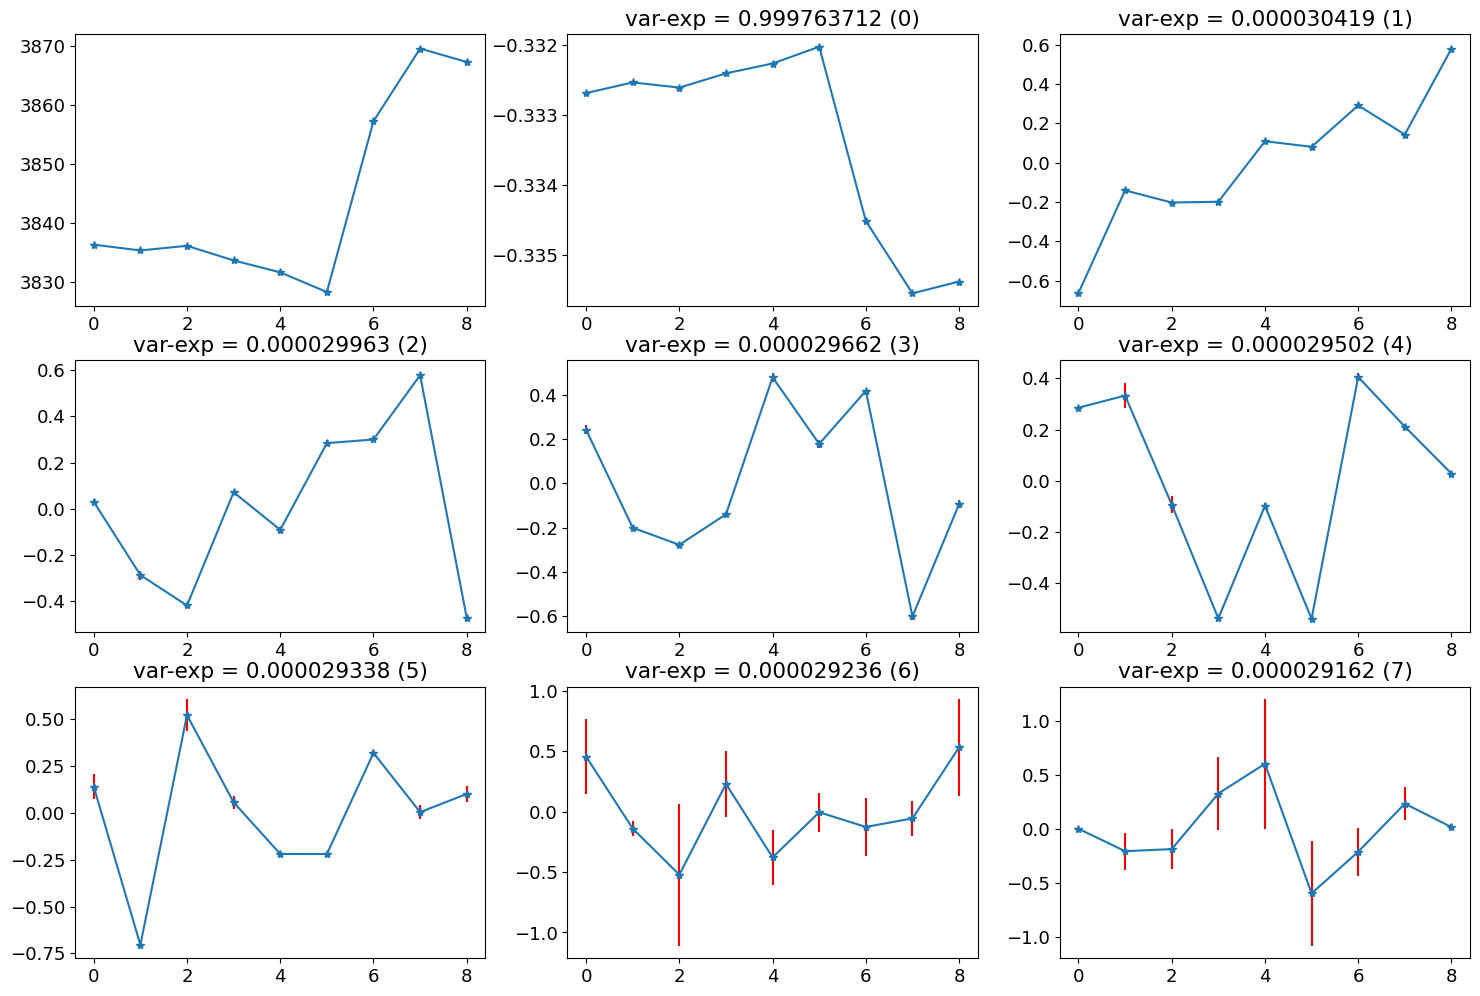

In [119]:
n_comp=8
fig, axs = plt.subplots(n_comp//3+1, 3, figsize=(18, 12))
axs = axs.flatten()

for comp in np.arange(n_comp):
    ax = axs[comp+1]
    #ax.plot(pca.components_[comp])
    ax.errorbar(np.arange(len(pca.components_[comp])), pca.components_[comp], yerr=comp_std[comp],ecolor='r', fmt='*-')
    ax.set_title(f"var-exp = {pca.explained_variance_ratio_[comp]:.9f} ({comp})")
axs[0].errorbar(np.arange(len(X_mean)), X_mean, yerr=mean_std, fmt='*-', ecolor='r')

The results show that most of the PCs appear stable with relatively negligible variation except for PCs \#4 and \#7 which appear to feature a significant variation.


To interpret this variability correctly, we must consider the change in eigen values from these PCs and neighbouring PCs. PCs with relatively close eigen values, together, define a subspace with a variance structure that is sensitive to noise. The presence of noise may readily induce another variance structure whose PCs are a random rotation of the original PC pair. Indeed, we notice that PC pairs \#5 \& \#6 and \#7 \& \#8 have eigen values that are relatively close, suggesting the noise induced variability may be a result of random rotations in the component pairs. The noise analysis thus shows that the PCs are relatively stable for most of the PCs, and in particular, the first few PCs which are key to the results presented.

## Specific PCs and Interpretation

### PC 1: Vignette Removal

The first image map, representing the projections onto the first PC and encodes the radial gradient in the image GSV, due to illumination artefacts. From the corresponding components, we see that this PC explains over $99.9\%$ of the variance  in the through plane profiles -- so much higher than all other components. This intensity variation due to the X-ray acquisition system is termed vignetting, and the high magnitude of variation explained by this effect, relative to other components, suggest that it may obscure useful saturation information in the data. The information provided by this PC and coefficients may however be used to estimate the vignetting effects which can then be used to correct the image data. As an example of this we show in figure below. The vignette component image is obtained by scaling the PC \#1 with the corresponding coefficients.

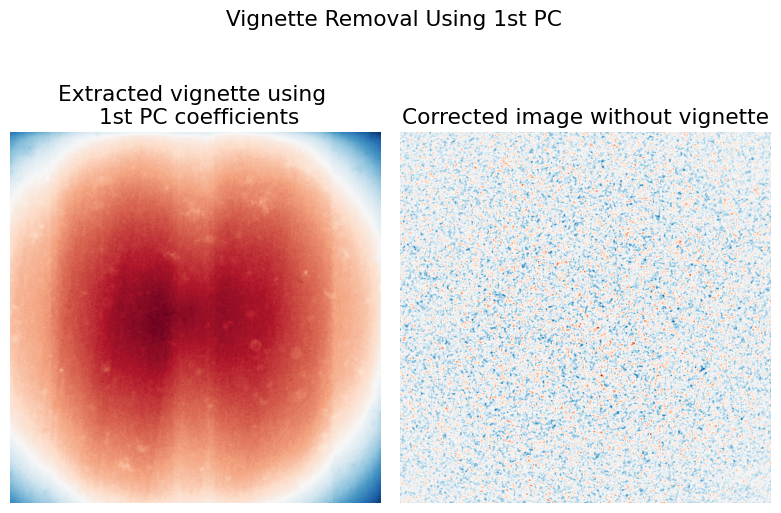

In [120]:
fig, axs = plt.subplots(nrows=1, ncols=2)

i = 0

p = axs[0].imshow(X_pca[:, i].reshape(filtered_im.shape[1], filtered_im.shape[2]), cmap='RdBu');
axs[0].axis('off')
axs[0].set_title('Extracted vignette using \n 1st PC coefficients');



X_proj = np.dot(X_pca[:, 0].reshape(-1, 1), pca.components_[0, :].reshape(1, -1) ) + X_mean.reshape(-1, im_shape[0])
X_proj = X_proj.T.reshape(n_seq, n_row, n_col)

filtered_im_no_vignette = filtered_im - X_proj
p = axs[1].imshow(filtered_im_no_vignette[0], cmap='RdBu')
axs[1].axis('off');
axs[1].set_title('Corrected image without vignette');

fig.suptitle(' Vignette Removal Using 1st PC')

fig.tight_layout()

# Save the full figure...
fig.savefig('../reports/images/vignette-removal.png')

### PC 2

The second of these PCs features a monotonous breakthrough profile indicating a gradual build up of liquid water from about the 160 seconds into operation.

From the image map, it can be seen here that the dominant breakthrough profile appears to be concentrated in the right channel in this case

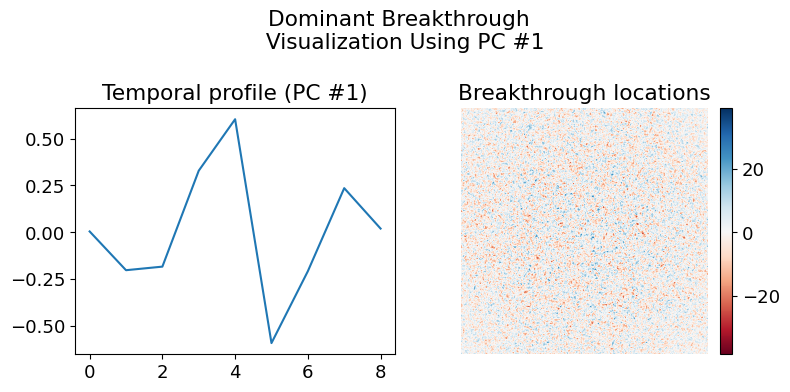

In [121]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axs[0].plot(pca.components_[comp])
axs[0].set_title('Temporal profile (PC #1)')

i = 1
p = axs[1].imshow(X_pca[:, i].reshape(filtered_im.shape[1], filtered_im.shape[2]), cmap='RdBu')
axs[1].axis('off')
axs[1].set_title('Breakthrough locations')
plt.colorbar(p, fraction=0.046, pad=0.04);



fig.suptitle('Dominant Breakthrough \n Visualization Using PC #1')
fig.tight_layout()



fig.savefig('../reports/images/pc1-major-break.png')

# Final Remarks

PCA has been used to extract and summarize liquid water breakthrough patterns from radiographic
image data for an operating fuel cell. This was achieved by analyzing the set of GSV profile, where each profile consists of the GSV recorded for a given point in the plane across the sequence of radiographs. 

The analysis of the transformed dataset yielded results including a set of principal components (PCs) and coefficients, with the coefficients reconstructed into image maps for interpretation. Together, these representations provide insights on the temporal profile, the distribution
of liquid water from the raw radiographs, and the correlation in breakthrough characteristics for
spatially distinct regions. 

We were also able to deduce dominant profiles as captured by PC #2 in
this case, suggesting the gradual build up of liquid water for identified regions. Further variation in the liquid water profiles captured by subsequent PCs showing slight deviations from the dominant profile given by PC #2, and the image map of coefficients for these show that there are spatial variations The variation in liquid water breakthrough patterns is also explained by the number of PCs with significant coefficients.

In addition to liquid water characterization, the first PC which captures the largest variance in the data is seen to represent the vignetting effects in the image. The image filtering capacity of this is then demonstrated by using it to correct the image - a procedure that is necessary to accurately make sense of the GSV information. Similarly, the method may also be used as a filtering mechanism through the elimination of low variance PCs representing noise.
The representation of the data afforded by the PCA as presented in this work, presents a huge po-
tential for analyzing radiographic X-ray data. 

Meanwhile, the method is limited by the linearity assumption the PCA imposes. This is easily broken as time progresses, and the method will be most suitable for short time interval for a slow dynamics.